# Credit Risk Analysis

## Credit risk database is a typical banking database containing information about loan applications. Usually it contains information on all parameters which are completed by the risk department in order to evaluate the applicants’ status and make the decision on the loan provision. 

- **Loan ID** - ID of the application in the database. Applied automatically by the system.
- **Gender** - select from the list Male or Female
- **Married** - marital status of the loan applicant, select from the list Yes or No
- **Dependents** - number of dependents of the loan applicant, select from the list 0, 1, 2 or 3+
- **Education** - educational level of the applicant, select from the list Graduate or Not Graduate
- **Self_Employed** - indicates whether the loan applicant has his private entrepreneurship, select from the list Yes or No
- **ApplicantIncome** - monthly average income in USD of the Loan applicant
- **CoapplicantIncome** -monthly average income in USD of the Loan applicant’s spouse
- **LoanAmount** - amount of the loan considered in thousands USD
- **Loan_Amount_Term** - loan length in months
- **Credit_History** - availability of previous credit history of the applicant, select from the list Yes or No
- **Property_Area** - property location classification according to the dictionary: Urban, Semiurban, Rural
- **Loan_Status** - the final decision made on the loan provision to the applicant, select from the list Y or N


In [1]:
#Importing libraries

import pandas as pd; import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder,RobustScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV,KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score,confusion_matrix,roc_auc_score,accuracy_score,classification_report
from scipy.stats import norm, skew
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier

import lightgbm as lgbm
import xgboost
from xgboost import  XGBClassifier
from catboost import CatBoostClassifier
from catboost import Pool

from scipy.stats import boxcox
import xgboost as xgb


from scipy import stats
from scipy.stats import norm, skew

import seaborn as sns
import matplotlib.pyplot as plt  

import warnings
warnings.filterwarnings('ignore')

print('Libraries imported')

Libraries imported


In [2]:
#Reading dataset

df = pd.read_csv('Credit_Risk.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## EDA - Exploratory Data Analysis & Preprocessing

In [3]:
print('Dataset have {} rows and {} columns'.format(df.shape[0],df.shape[1]))

Dataset have 614 rows and 13 columns


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


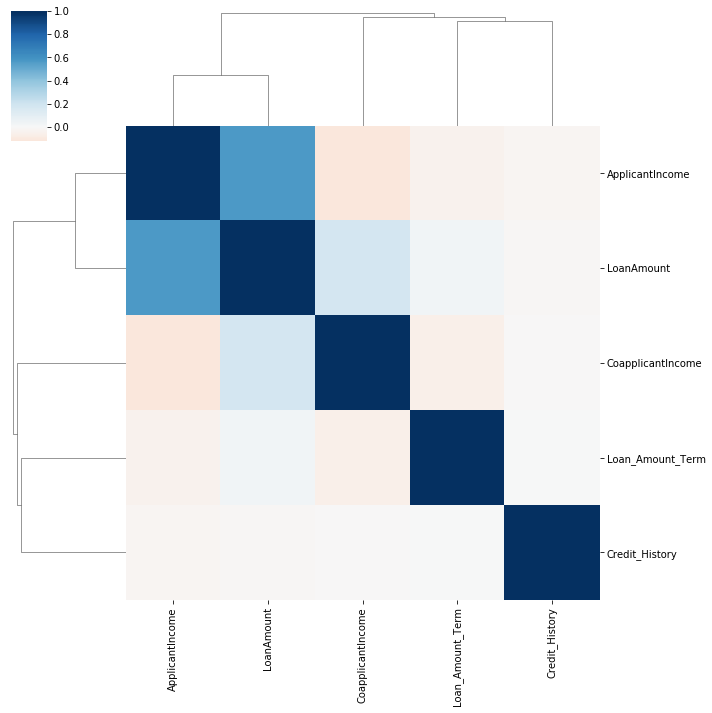

In [6]:
sns.clustermap(df.corr(), cmap='RdBu',center=0)

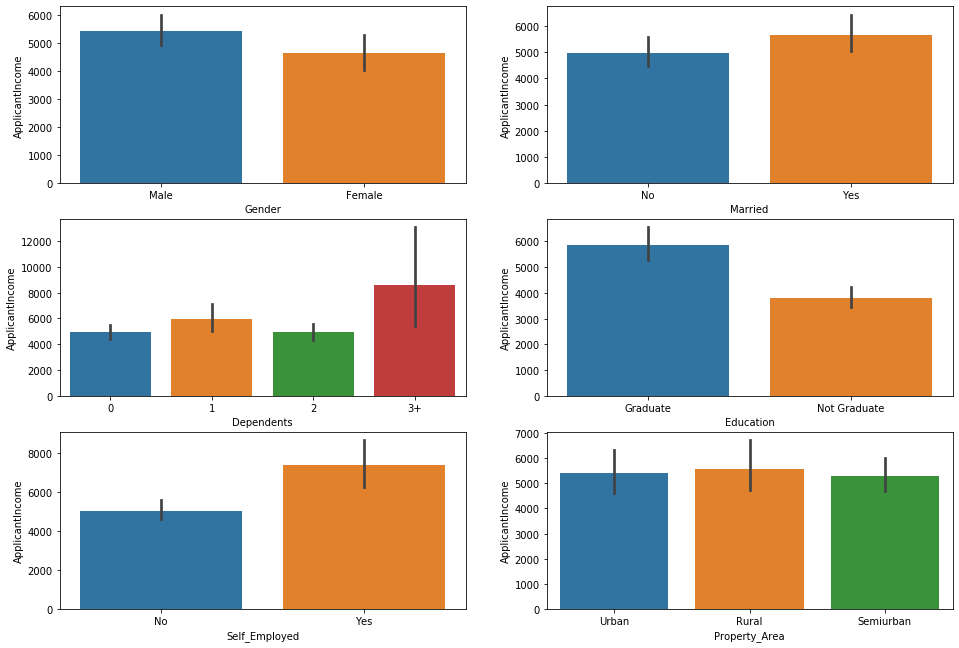

In [7]:
#  Categorical Data by Applicants income

m = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']

fig = plt.figure(figsize=(16,15))
c=1
for i in m:  
    plt.subplot(4, 2, c)
    #plt.title('{}, subplot: {}{}{}'.format(i, 4, 2, c))
    plt.xlabel(i)
    sns.barplot(x = df[i],y=df['ApplicantIncome'])
    c = c + 1

plt.show()

Y    422
N    192
Name: Loan_Status, dtype: int64
Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64


Text(0.5, 1.0, 'Target variable')

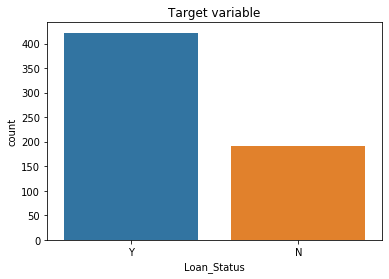

In [8]:
target = 'Loan_Status'
print(df[target].value_counts())
print(df[target].value_counts(normalize=True))
sns.countplot(df[target])
plt.title('Target variable')

In [9]:
missing_data = pd.DataFrame({'total_missing': df.isnull().sum(), '% missing': (df.isnull().sum()/df.shape[0])*100})
missing_data

,total_missing,% missing
Loan_ID,0,0.000000
Gender,13,2.117264
Married,3,0.488599
Dependents,15,2.442997
Education,0,0.000000
Self_Employed,32,5.211726
ApplicantIncome,0,0.000000
CoapplicantIncome,0,0.000000
LoanAmount,22,3.583062
Loan_Amount_Term,14,2.280130


In [10]:
#For the missing values in the catoorical features we can fill by their mode values.

for i in df.columns:
    if df[i].nunique()<=10:
        df[i].fillna(df[i].mode()[0],inplace=True)
        
        
df['LoanAmount'].fillna(round(df['LoanAmount'].mean(),2),inplace=True)
df['Credit_History'].fillna(1,inplace=True)

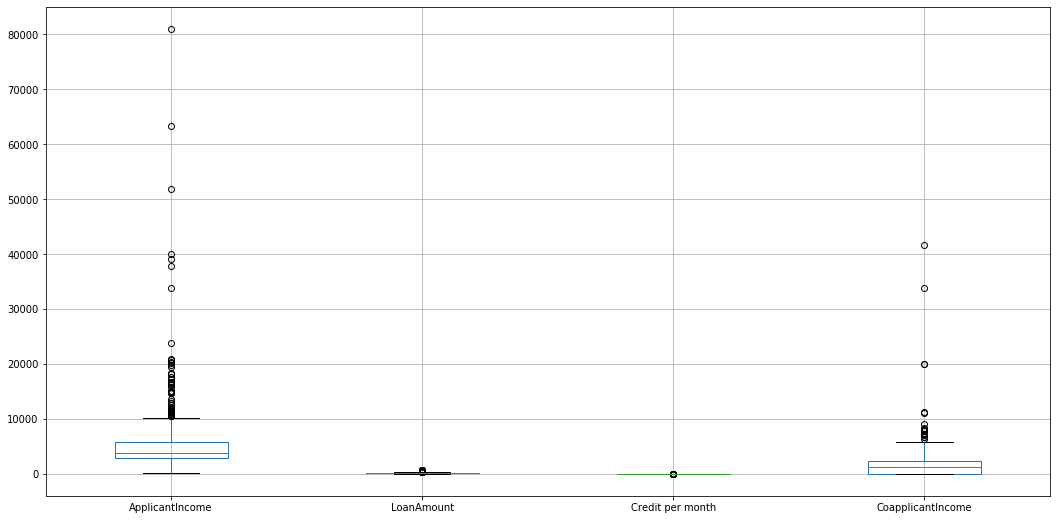

In [11]:
#We can add a new feature by dividing Loan amount by Loan Amount term which gives us monthly credit payments
df["Credit per month"] = df["LoanAmount"]/df["Loan_Amount_Term"]
m = ['ApplicantIncome','LoanAmount','Credit per month','CoapplicantIncome']
plt.figure(figsize=(18,9))
df[m].boxplot()
plt.show()

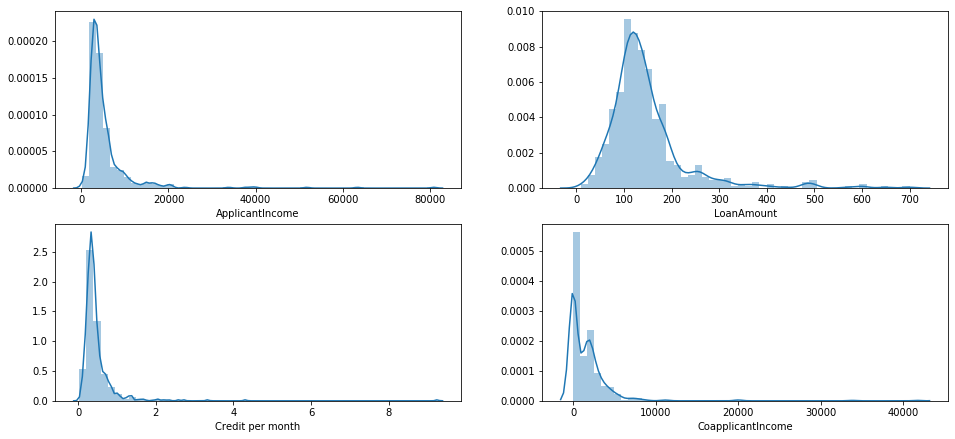

In [12]:
fig = plt.figure(figsize=(16,15))
c=1
for i in m:  
    plt.subplot(4, 2, c)
    #plt.title('{}, subplot: {}{}{}'.format(i, 4, 2, c))
    plt.xlabel(i)
    sns.distplot(df[i])
    c = c + 1

plt.show()

We can see our **ApplicantIncome, Credit per month, CoapplicantIncome, LoanAmount** columns have so many outliers which will have a negativ effect on our ml models.

For the normalizaton we will apply log1p normalization to skewed data

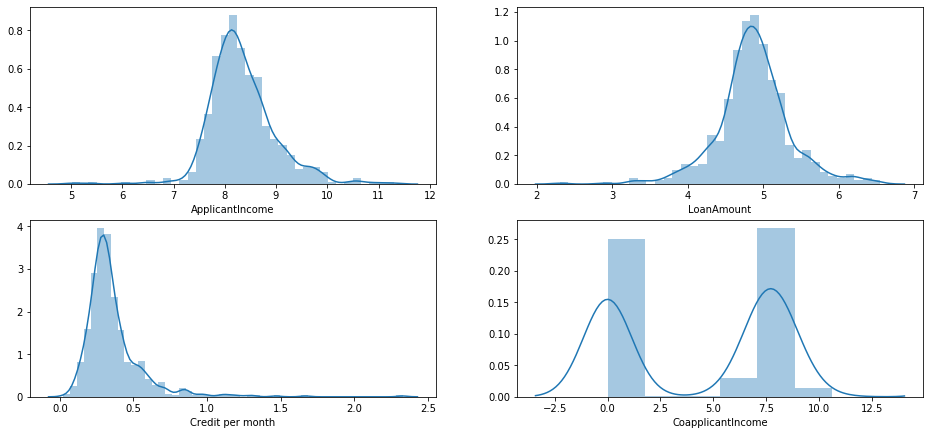

In [13]:
fig = plt.figure(figsize=(16,15))
c=1
for i in m:
    df[i] = np.log1p(df[i])
    plt.subplot(4, 2, c)
    #plt.title('{}, subplot: {}{}{}'.format(i, 4, 2, c))
    plt.xlabel(i)
    sns.distplot(df[i])
    c = c + 1
    

It seems less skewed after transformation

### Feature Engineering

In [14]:
#We will remove Loan_ID as it has no affect

df.drop(['Loan_ID'],axis=1,inplace=True)

df['Loan_Amount_Term'] = df['Loan_Amount_Term'].astype(str) # In order to apply encoding
df['Loan_Status'] = df['Loan_Status'].replace(['Y','N'],[1,0])
df['Credit_History'] = df['Credit_History'].astype(str)

We won't apply enconding as we will use it inside pipelines or model

## Building and Training Models

In [125]:
features = [x for x in df.columns if x!=target] 

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0
                                                   )

object_feats  = X.dtypes[X.dtypes == "object"].index.tolist()
numeric_feats = X.dtypes[X.dtypes != "object"].index.tolist()


Logistic Regression with Grid Seacrh

We will use **grid search** for hypterparameter tuning for our models

In [17]:
def accuracy(X,y,model): #The function for accuracy metrics
    f1 =f1_score(y,model.predict(X))
    roc = roc_auc_score(y,model.predict(X))
    a_s =accuracy_score(y,model.predict(X))
    ac = pd.DataFrame({'Accuracy':[f1,roc,a_s]},index=['F1','ROC','Acc Sc'])
    return ac
    
def conf_matrix(X,y,model):
    return pd.DataFrame(confusion_matrix(y,model.predict(X)))
   


In [18]:
#Prepocessing step for pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), object_feats),#Onehot encoding for categorical features
        ('num', StandardScaler() , numeric_feats) #Scaling for numeric features
    ])

In [19]:
# Logregession model
estimator = Pipeline([("pre", preprocessor),
        ("log_regression", LogisticRegression())])

params = {
    'log_regression__max_iter': [100,500,1000,5000],
    'log_regression__penalty':["l1","l2",'elastic_net'],
    'log_regression__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'log_regression__C':[1,5,10]
}

log_grid = GridSearchCV(estimator, params, cv=3)
log_grid.fit(X,y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'Married',
                                                                          'Dependents',
                                                                          'Education',
                                                                          'Self_Employed',
                                                                          'Loan_Amount_Term',
                                                                          'Credit_History',
                                                                          'Property_Area']),
                           

In [20]:

accuracy(X,y,log_grid)

,Accuracy
F1,0.875928
ROC,0.708086
Acc Sc,0.809446


In [21]:
print("Best score --",log_grid.best_score_)
print("Parameters --",log_grid.best_params_)

Best score -- 0.8029650884744143
Parameters -- {'log_regression__C': 1, 'log_regression__max_iter': 100, 'log_regression__penalty': 'l1', 'log_regression__solver': 'liblinear'}


RandomForest Classifier with Grid Search

ExtraTree Classifier

In [25]:
ExtraTreesClassifier

estimator = Pipeline([("pre", preprocessor),
        ("etc", ExtraTreesClassifier())])

params = {
    'etc__n_estimators': [15,30, 40, 50, 100, 300, 400],
    'etc__criterion':["gini", "entropy"]    
}

etc_grid = GridSearchCV(estimator, params, cv=5)
etc_grid.fit(X,y)
print("Best score --",etc_grid.best_score_)
print("Parameters --",etc_grid.best_params_)

Best score -- 0.7523523923763827
Parameters -- {'etc__criterion': 'gini', 'etc__n_estimators': 40}


In [26]:
accuracy(X,y,etc_grid)

,Accuracy
F1,1.0
ROC,1.0
Acc Sc,1.0


ExtraTree Classifier seems like overfit the model even with cross validation

XGBoost Classifier

In [27]:
estimator = Pipeline([("pre", preprocessor),
        ("xgb", XGBClassifier())])

params = {
    'xgb__booster': ['gbtree', 'gblinear', 'dart'],
    'xgb__n_estimetors':[50,100,200,500,1000],
    'xgb__learning_rate':[0.001,0.01,0.1]
    
    
}

xg_grid = GridSearchCV(estimator, params, cv=5)
xg_grid.fit(X,y)
print("Best score --",xg_grid.best_score_)
print("Parameters --",xg_grid.best_params_)

[12:55:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:55:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:55:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:55:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:55:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:55:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:55:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:55:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:55:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:55:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:55:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:55:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:55:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:55:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:55:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n


[12:55:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the o


[12:55:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the o

[12:55:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:55:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n


[12:55:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the o


[12:56:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the o

[12:56:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the ol


[12:56:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the o

[12:56:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n


[12:56:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the o


[12:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the o

[12:56:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the ol

[12:56:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:56:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:56:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:56:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:56:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:56:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:57:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:57:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:57:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:57:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:57:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:57:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:57:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:57:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:57:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:57:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:57:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:57:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:58:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:58:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:58:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:58:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:58:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:58:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[12:58:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:58:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimetors" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'Married',
                                                                          'Dependents',
                                                                          'Education',
                                                                          'Self_Employed',
                                                                          'Loan_Amount_Term',
                                                                          'Credit_History',
                                                                          'Property_Area']),
                           

In [28]:
accuracy(X,y,xg_grid)

,Accuracy
F1,0.877119
ROC,0.709271
Acc Sc,0.811075


In [29]:
conf_matrix(X,y,xg_grid)

,0,1
0,84,108
1,8,414


XGBoost, as always, did good job 

Light LGBM

In [30]:
estimator = Pipeline([("pre", preprocessor),
        ("lgb", lgbm.LGBMClassifier())])

params = {
    'lgb__boosting_type': ['gbdt','dart','goss','rf'],
    'lgb__n_estimetors':[50,100,200,300,400,500],
    'lgb__learning_rate':[0.001,0.01,0.1,0.5]
    
    
}

lgb_grid = GridSearchCV(estimator, params, cv=10)
lgb_grid.fit(X,y)
print("Best score --",lgb_grid.best_score_)
print("Parameters --",lgb_grid.best_params_)

[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_esti

[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_esti

[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_esti

[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_esti

[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_estimetors
[LightGBM] [Warning] Unknown parameter: n_esti

In [31]:
accuracy(X,y,lgb_grid)

,Accuracy
F1,0.876452
ROC,0.705248
Acc Sc,0.809446


CatBoost Classifier

CatBoost is an open-source gradient boosting on decision trees library developed by Yandex. CatBoost can be used for solving problems, such as: classification (binary, multi-class) ,regression,ranking. 
- For data with categorical features the accuracy of CatBoost would be better compared to other algorithms. You do not need to preprocess categorical features (like one-hot encoding), just specify some hyperparameters (will be shown below, we will also use HP for hyperparameters)
- CatBoost uses the implementation of ordered boosting, an alternative to the classic boosting algorithm.
For example, the gradient boosting is quickly overfitted on small datasets. In Catboost there is a special modification for such cases, so on small datasets where other algorithms had a problem of overfitting you won’t observe the same problem with Catboost

In [32]:
CatBoostClassifier

catboost.core.CatBoostClassifier

In [198]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

cat_model=CatBoostClassifier(iterations=200, depth=4, learning_rate=0.1,eval_metric= 'F1' ,
                         loss_function='Logloss',verbose=100
                        )
cat_model.fit(X_train, y_train,use_best_model=True,
          cat_features=categorical_features_indices,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8717156	test: 0.8911565	best: 0.8911565 (0)	total: 15.7ms	remaining: 3.12s
100:	learn: 0.9073482	test: 0.8843537	best: 0.8949153 (1)	total: 2.29s	remaining: 2.25s
199:	learn: 0.9357496	test: 0.8611111	best: 0.8949153 (1)	total: 4.45s	remaining: 0us

bestTest = 0.8949152542
bestIteration = 1

Shrink model to first 2 iterations.


In [199]:
accuracy(X_test,y_test,cat_model)

,Accuracy
F1,0.894915
ROC,0.708224
Acc Sc,0.832432


GradientBoosting Classifier

In [281]:
estimator = Pipeline([("pre", preprocessor),
        ("gbc", GradientBoostingClassifier())])

params = {
    
    'gbc__n_estimators':[50,100,200,300,400,500],
    'gbc__learning_rate':[0.1, 0.01, 0.001, 0.0001],
    'gbc__subsample': [1.0, 0.5],
    'gbc__max_features': [1, 2, 3, 4]
    
    
}

gb_grid = GridSearchCV(estimator, params,scoring='accuracy',
                      n_jobs=-1, cv=4)
gb_grid.fit(X,y)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'Married',
                                                                          'Dependents',
                                                                          'Education',
                                                                          'Self_Employed',
                                                                          'Loan_Amount_Term',
                                                                          'Credit_History',
                                                                          'Property_Area']),
                           

In [282]:
accuracy(X,y,gb_grid)

,Accuracy
F1,0.885106
ROC,0.727266
Acc Sc,0.824104


All scores

In [283]:
models = ['LogReg','ExtraTree','XgBoosting','LGBM','CatBoost','GradientBoost']
scores = pd.DataFrame([accuracy(X,y,log_grid)['Accuracy'].values,
accuracy(X,y,etc_grid)['Accuracy'].values,
accuracy(X,y,xg_grid)['Accuracy'].values,
accuracy(X,y,lgb_grid)['Accuracy'].values,
accuracy(X_test,y_test,cat_model)['Accuracy'].values,
accuracy(X,y,gb_grid)['Accuracy'].values],columns=['F1 score','ROC','Accuracy score'],index=models).T
scores

,LogReg,ExtraTree,XgBoosting,LGBM,CatBoost,GradientBoost
F1 score,0.875928,1.0,0.877119,0.876452,0.894915,0.885106
ROC,0.708086,1.0,0.709271,0.705248,0.708224,0.727266
Accuracy score,0.809446,1.0,0.811075,0.809446,0.832432,0.824104


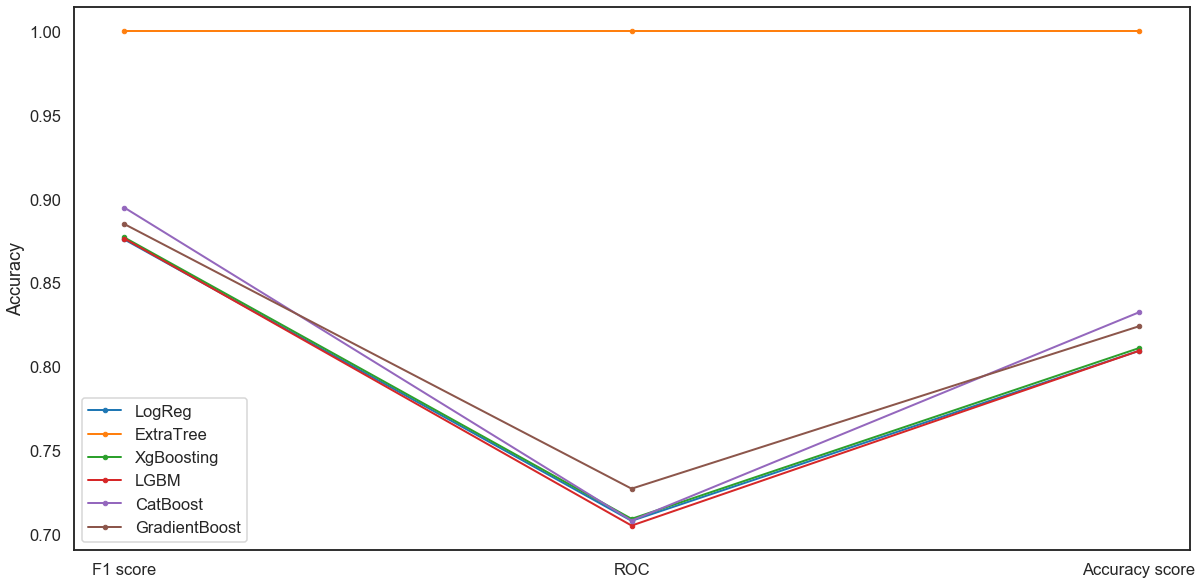

In [284]:
sns.set_context('talk')
sns.set_style('white')

ax = scores.plot(marker='.', figsize=(20, 10), linewidth=2)
ax.set(ylabel='Accuracy');

Text(0.5, 1, 'CatBoost Classifier')

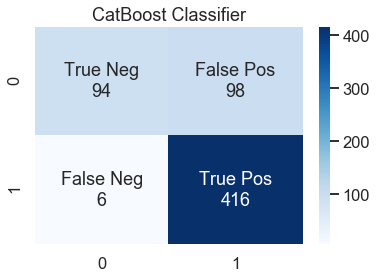

In [269]:
cm = confusion_matrix(y,gb_grid.predict(X))
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_names = ['True Neg','False Pos','False Neg','True Pos']
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.title('CatBoost Classifier')

## **Conclusion**
 - ExtraTree Classifier has overfitting problem and seems that it is not a good choice for this dataset, so we can not take it to the account.
 - CatBoost and Gradient Descent Boosting have slighly higher accuracy scores than others. As the graph shows,while ROC_AUC score is higher in GDB , CatB has the highest F1_score.However, the models can be **improved** by adding more observations to the dataset.The dataset just have 614 rows which make it difficult to build a powerful risk model.